In [1]:
!wget https://raw.githubusercontent.com/zaidalyafeai/assignment/main/catalogs.zip
!unzip catalogs.zip

--2021-04-11 11:24:38--  https://raw.githubusercontent.com/zaidalyafeai/assignment/main/catalogs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377695 (369K) [application/zip]
Saving to: ‘catalogs.zip’

catalogs.zip        100%[===================>] 368.84K  --.-KB/s    in 0.05s   

2021-04-11 11:24:38 (7.96 MB/s) - ‘catalogs.zip’ saved [377695/377695]

Archive:  catalogs.zip
   creating: catalogs/
  inflating: catalogs/tv_catalog.json  
  inflating: catalogs/lit_catalog.json  
  inflating: catalogs/ck_catalog.json  
  inflating: catalogs/g_catalog.json  


In [2]:
import nltk
import urllib.request
import os 
import json 
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Extraction/Cleaning

Create a class for extracting and cleaning threads per channel

In [3]:
class Channel:
  def __init__(self, name, max_threads = 100):
    '''
    Process each channel and extract different attributes
    '''
    url = f'https://a.4cdn.org/{name}/catalog.json '
    out_path = f'catalogs/{name}_catalog.json'
    if os.path.exists(out_path):
      pass
    else:
      urllib.request.urlretrieve(url, filename=out_path)
    with open(out_path, 'r') as f:
      self.catalog = json.loads(f.read())
    
    self.attrs = ['now', 'images', 'md5', 'filename', 'last_replies', 'h', 'name', 'w', 'imagelimit', 'ext', 'com', 'semantic_url', 'tn_w', 'fsize', 'tim', 'replies', 'omitted_posts', 'trip', 'bumplimit', 'time', 'tn_h', 'omitted_images', 'closed', 'resto', 'capcode', 'last_modified', 'sub', 'no', 'custom_spoiler', 'sticky']
    self.special_elements = ['&gt', '039', 'thread', 'class', 'post', 'quote']
    self.puncts = list(punctuation) +["’", "`","...", "''"]
    self.max_threads = max_threads 
  def get_threads(self):
    '''
    Extract all the threads of a given channel 
    '''
    threads = []
    for page in self.catalog :
      for thread in page['threads']:
        if len(threads) >= self.max_threads:
          return threads
        reply = {}
        for attr in self.attrs:
          if attr in thread:
            content = thread[attr]
            if attr == 'com':
              content = self._process_com(content)
            reply[attr] = content
          else:
            reply[attr] = -1
        threads.append(reply) 
    return threads

  def _process_com(self, com):
    '''
    preprocess a commentary 
    '''
    com = self._remove_links(com)
    com = self._remove_html_elments(com)
    com = self._remove_special_elements(com)
    com = self._remove_puncts(com)
    return com.lower()

  def _remove_puncts(self, text):
    '''
    remove punctuations 
    '''
    for el in self.puncts:
      text = text.replace(el, '')
    return text

  def _remove_html_elments(self, text):
    '''
    remove html elements
    '''
    cleanr = re.compile("<.*?>")
    text = re.sub(cleanr, "", text)
    return text
  
  def _remove_special_elements(self, text):
    '''
    remove some extra elements 
    '''
    for el in self.special_elements:
      text = text.replace(el, '')
    return text
    

  def _remove_links(self, text):
    '''
    remove links 
    '''
    text = re.sub(r"http\S+", " ", text, flags=re.MULTILINE)
    return text

Pull up threads

In [4]:
channels = {'g':[], 'tv':[], 'ck':[], 'lit':[]}
channel_names = {'g':'Technology', 'tv':'TV & Film', 'ck':'Food & Cooking', 'lit':'Literature'}

## extract threads and print num of threads per channel
for c in channels:
  channels[c] = Channel(c).get_threads()
  print(channel_names[c], len(channels[c]))

Technology 100
TV & Film 100
Food & Cooking 100
Literature 100


sample entry

In [5]:
channels['g'][0]

{'bumplimit': -1,
 'capcode': 'mod',
 'closed': 1,
 'com': 'this board is for the discussion of technology and related topics  \nreminder that instigating or participating in flamebrand wars will result in a ban\ntech support s should be ed to wsr \ncryptocurrency discussion belongs on biz  to use the code tag bookend your body of code with co\xadde and co\xadde  the g wiki a href ',
 'custom_spoiler': -1,
 'ext': '.png',
 'filename': 'sticky btfo',
 'fsize': 310766,
 'h': 420,
 'imagelimit': -1,
 'images': 3,
 'last_modified': 1608861974,
 'last_replies': [{'capcode': 'mod',
   'ext': '.png',
   'filename': 'RMS',
   'fsize': 299699,
   'h': 399,
   'md5': 'cEeDnXfLWSsu3+A/HIZkuw==',
   'name': 'Anonymous',
   'no': 76759448,
   'now': '07/13/20(Mon)20:33:58',
   'resto': 76759434,
   'tim': 1594686838367,
   'time': 1594686838,
   'tn_h': 110,
   'tn_w': 125,
   'w': 450}],
 'md5': 'fXlzSIjoI0KSQVKti3l+Eg==',
 'name': 'Anonymous',
 'no': 76759434,
 'now': '07/13/20(Mon)20:33:00',
 'o

## Exploratory Analysis

Calculate frequency of each word in the comments 

In [6]:
from collections import Counter
from nltk.tokenize import word_tokenize

def get_freqs(channels, remove_stop_words = True, attr = 'com'):
  '''
  get the frequency distribution of words in a given attribute
  '''
  stop_words = stopwords.words('english')
  special_chars = ['']
  freqs = {c:[] for c in channels}
  for c in channels:
    freq = Counter()
    threads = channels[c]
    for thread in threads:
      if thread[attr] == -1:
        continue
      if attr == 'com':
        for word in word_tokenize(thread[attr]):
          if word not in stop_words and remove_stop_words:
            freq[word] += 1
      else:
        freq[thread[attr]] += 1
    freqs[c] = freq
  return freqs 

plot frequency of words

Technology


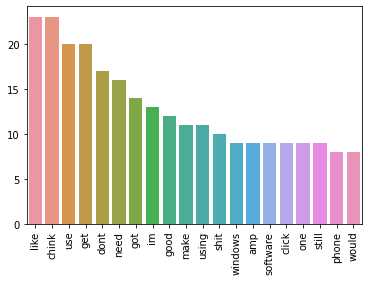

TV & Film


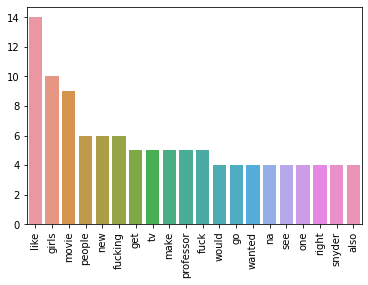

Food & Cooking


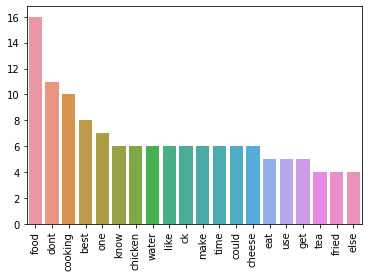

Literature


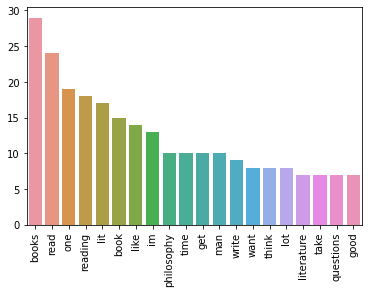

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

freqs = get_freqs(channels, attr = 'com')

for c in channels:
  print(channel_names[c])
  d = freqs[c].most_common(20)
  keys = [key[0] for key in d]
  vals = [key[1] for key in d]
  g = sns.barplot(x=keys, y=vals)
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
  plt.show()

Show the number of closed threads per channel

In [8]:
freqs = get_freqs(channels, attr = 'closed')
for c in channels:
  
  d = freqs[c].most_common(2)
  num_closed_threads = 0
  if len(d) >= 1:
    num_closed_threads = d[0][1]
    
  print()
  print(f'{channel_names[c]} has {num_closed_threads} closed threads ')


Technology has 1 closed threads 

TV & Film has 0 closed threads 

Food & Cooking has 0 closed threads 

Literature has 1 closed threads 


Show distirubtion of posts by time

In [9]:
from datetime import datetime

freqs = get_freqs(channels, attr = 'now')
dates_per_channel = {c:[] for c in channels}
for c in channels:
  
  d = freqs[c]
  dates = []
  for el in d:
    # extract date and convert ot format
    date = el.split('(')[0]
    year = date.split('/')[-1]
    date = date.replace(year, '20'+year)
    time = el.split(')')[1]
    dt_obj = datetime.strptime(date+' '+time,
                           '%m/%d/%Y %H:%M:%S')
    dates.append(dt_obj)
  dates_per_channel[c] = dates

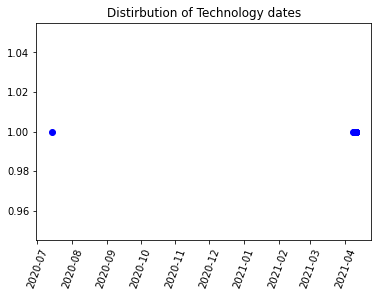

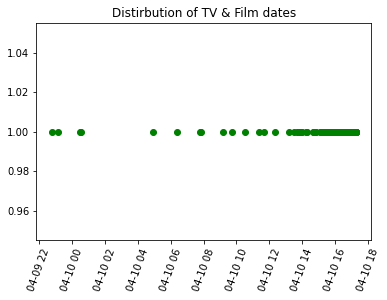

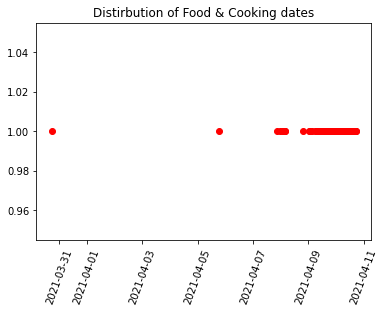

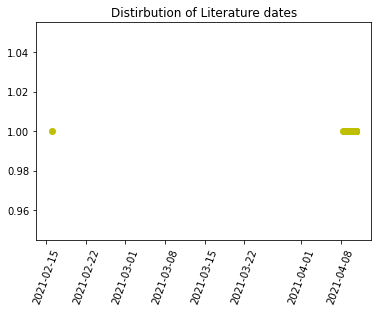

In [12]:
import matplotlib
colors = ['b', 'g', 'r', 'y']
for i, c in enumerate(dates_per_channel):
  dates = matplotlib.dates.date2num(dates_per_channel[c])
  plt.xticks(rotation=70)
  plt.plot_date(dates, [1] *len(dates), color = colors[i])
  plt.title(f'Distirbution of {channel_names[c]} dates')
  plt.show()

### Data Encoding

Collect data and labels

In [13]:
data = []
labels = []

for i, c in enumerate(channels):
  threads = channels[c]
  for thread in threads:
      data.append(thread)
      labels.append(i)

Encode data using BoW

In [14]:
class Encoder:

  def __init__(self, data):
    '''
    encode a set of comments using BoW algorithm 
    '''
    self.vocab = []
    self.data = ''
    stop_words = stopwords.words('english')
    for thread in data:
      com = thread['com']
      if com == -1:
        continue
      for word in word_tokenize(com):
        if word not in stop_words:
          self.vocab.append(word)
    self.vocab = list(set(self.vocab))
    
  def encode(self, data):
    '''
    encode a given data using the vocab 
    '''
    encodings = []
    for thread in data:
      com = thread['com']
      enc = [0] * len(self.vocab)
      if com != -1:
        for word in word_tokenize(com):
          if word in self.vocab:
            idx = self.vocab.index(word)
            enc[idx] += 1
      encodings.append(enc)
    return encodings

In [15]:
bow_encoder = Encoder(data)
X = bow_encoder.encode(data)
y = labels

Encode data into training and testing

## Discriminative Analysis

We use an Treeclassifier for freature selection

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

Extract the most discriminative features

In [17]:
for i, word in enumerate(bow_encoder.vocab):
  score = clf.feature_importances_[i]
  if score > 0.005:
    print(word, score) 

desktop 0.00608148017036507
eat 0.008954264273227963
reading 0.015081450245566761
book 0.009928978740301977
books 0.024075430861415677
use 0.007979980494176772
write 0.006060711587031674
food 0.010502209038468774
lit 0.014389951925247618
movie 0.011725116609779276
ck 0.011296229524360414
software 0.006261312361324492
tv 0.005747259508330609
cooking 0.006047689745461633
philosophy 0.005427032972355205
g 0.005199076375226041
read 0.0129649407702196
technology 0.005931883486766837
linux 0.007515350544468727
c 0.005259363517598889
really 0.006620229371154792


split the data

In [18]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_new, y, train_size = 0.95, random_state = 0)

Train the model

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C=100.0, kernel='rbf').fit(xtrain, ytrain)
ypred = clf.predict(xtest)

print('accuracy ', accuracy_score(ytest, ypred))

accuracy  0.7


In [20]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(ytest, ypred))

[[2 1 0 1]
 [0 6 1 1]
 [0 0 4 1]
 [0 0 1 2]]


## References 


1.   https://medium.datadriveninvestor.com/how-to-use-the-4chan-json-api-with-python-building-a-dataset-for-machine-learning-part-1-ac36ad4c4be2
2.   https://github.com/4chan/4chan-API/blob/master/pages/Catalog.md
3.   https://scikit-learn.org/stable/modules/feature_selection.html

